In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.7.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# U-Net For Image Segmentation

## Data Preprocessing

In [5]:
# input dimensions
width = 128
height = 128
num_channels = 3

train_path = 'stage1_train/'
test_path = 'stage1_test/'

train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

x_train = np.zeros((len(train_ids), height, width, num_channels), dtype=np.uint8)
y_train = np.zeros((len(train_ids), height, width, 1), dtype=bool)

print('Resizing Training Images and Masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:num_channels]
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    x_train[n] = img
    mask = np.zeros((height, width, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_el = imread(path + '/masks/' + mask_file)
        mask_el = np.expand_dims(resize(mask_el, (height, width), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_el)
        
    y_train[n] = mask
    
    
x_test = np.zeros((len(test_ids), height, width, num_channels), dtype=np.uint8)
test_sizes = []
print('Resizing Test Images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:num_channels]
    test_sizes.append([img.shape[0], img.shape[1]])
    img = resize(img, (height, width), mode='constant', preserve_range=True)
    x_test[n] = img
    
print('Done')
    
# https://www.youtube.com/watch?v=cUHPL_dk17E&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=5

Resizing Training Images and Masks


100%|█████████████████████████████████████████| 670/670 [03:24<00:00,  3.28it/s]


Resizing Test Images


100%|███████████████████████████████████████████| 65/65 [00:01<00:00, 58.93it/s]

Done


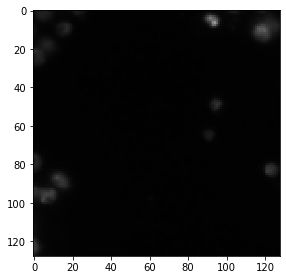

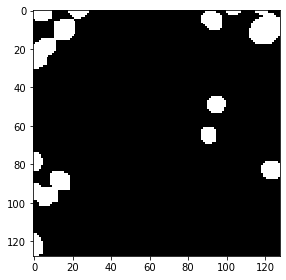

In [6]:
image_x = random.randint(0, len(train_ids)) # picking a random image
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

## Building U-Net Model

In [7]:
len(x_train)

670

In [8]:
inputs = tf.keras.layers.Input((width, height, num_channels))
print(type(inputs))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting input values from integers to floating point values.

#### Convolutional Layers ####

## Contraction Path (Down the "U") ##
c1 = tf.keras.layers.Conv2D(16, (3,3),  # the "(3,3)" is the kernel shape
                            activation='relu', 
                            kernel_initializer='he_normal',# the kernel_initializer is defining initial weights. #### https://www.tensorflow.org/api_docs/python/tf/keras/initializers ####                             
                            padding='same')(s) # padding='same' means that it pads such that the output image has the same dimensions as the input image

c1 = tf.keras.layers.Dropout(0.1)(c1) # dropout prevents overfitting
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
                            
                            
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
                            

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

                            
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
                            
                            
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

                            

## Expanding Path (Up the "U") ##
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

                            
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
                            
                            
u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
                            
                            
u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
                            
                            

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
                            
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
Metal device set to: Apple M1 Pro


2022-04-27 10:29:53.424740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-27 10:29:53.425093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

## Fitting the Model

In [9]:
# Model checkpoint callback: 
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model for nuclei.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
with tf.device('/GPU:0'):
    results = model.fit(x_train, 
                        y_train, 
                        validation_split=0.2,
                        batch_size=16,
                        epochs=30,
                        callbacks=callbacks)

Epoch 1/30


2022-04-27 10:29:54.060652: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-27 10:29:54.537654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.7237

2022-04-27 10:30:00.326582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 7s 101ms/step - loss: 0.5971 - accuracy: 0.7237 - val_loss: 0.3872 - val_accuracy: 0.7516
Epoch 2/30
34/34 [==============================] - 2s 71ms/step - loss: 0.3047 - accuracy: 0.8274 - val_loss: 0.2772 - val_accuracy: 0.8916
Epoch 3/30
34/34 [==============================] - 2s 71ms/step - loss: 0.2001 - accuracy: 0.9277 - val_loss: 0.1736 - val_accuracy: 0.9321
Epoch 4/30
34/34 [==============================] - 2s 70ms/step - loss: 0.1429 - accuracy: 0.9459 - val_loss: 0.1493 - val_accuracy: 0.9440
Epoch 5/30
34/34 [==============================] - 2s 70ms/step - loss: 0.1261 - accuracy: 0.9520 - val_loss: 0.1265 - val_accuracy: 0.9492
Epoch 6/30
34/34 [==============================] - 2s 69ms/step - loss: 0.1197 - accuracy: 0.9553 - val_loss: 0.1194 - val_accuracy: 0.9539
Epoch 7/30
34/34 [==============================] - 2s 70ms/step - loss: 0.1141 - accuracy: 0.9567 - val_loss: 0.1134 - val_accuracy: 0.9553
Epoch 8/30
34/34 [=====

In [10]:
predictions = model.predict(x_test, verbose=1)
val_predictions = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_treshold = (predictions > 0.5).astype(np.uint8)
val_pred_threshold = (val_predictions > 0.5).astype(np.uint8)

1/3 [=========>....................] - ETA: 0s

2022-04-27 10:30:32.036814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 164ms/step


In [11]:
!tensorboard --logdir='logs/' --host localhost --port 8088


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.6.0 at http://localhost:8088/ (Press CTRL+C to quit)
^C


Text(0.5, 1.0, 'Prediction:')

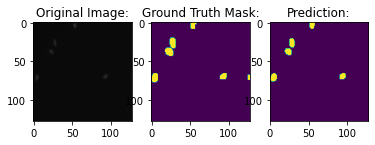

In [12]:
fig, ax = plt.subplots(1,3)
image_x = random.randint(0, len(val_pred_threshold)) # picking a random image

ax[0].imshow(x_train[int(x_train.shape[0]*0.9):][image_x])
ax[0].set_title("Original Image:")

ax[1].imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][image_x]))
ax[1].set_title("Ground Truth Mask:")

ax[2].imshow(np.squeeze(val_pred_threshold[image_x]))
ax[2].set_title("Prediction:")